# Input data

In [36]:
import urllib.request 
url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt") 
file_path = "the-verdict.txt" 
urllib.request.urlretrieve(url, file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x7d12afeadb10>)

In [37]:
with open("the-verdict.txt","r",encoding="utf-8") as f:
    raw_text = f.read()

print("Total chareacter", len(raw_text))
print(raw_text[:99])

Total chareacter 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


# Tokenization
Converts raw text to numbers 

In [38]:
# The following code will tokenize the text into words

import re
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text) 
preprocessed = [item.strip() for item in preprocessed if item.strip()] 
print(f'Length of token {len(preprocessed)}')
print(preprocessed[:30])

Length of token 4690
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [39]:
# Get unique set of words from the tokenized list
all_words = sorted(set(preprocessed)) 
vocab_size = len(all_words)
print(f'unique vocabulary {vocab_size}')

vocab = {token:integer for integer,token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
    print(item) 
    if i >= 50: 
        break

unique vocabulary 1130
('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


## Simple Tokenizer 

Created simple tokenizer to encode and decode raw text into token and vize versa

In [40]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
                                
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know, Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(f'Text : {text}')
print(f'Tokens: {ids}')
print(f'Decoded: {tokenizer.decode(ids)}')

Text : "It's the last he painted, you know, Mrs. Gisburn said with pardonable pride.
Tokens: [1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 67, 7, 38, 851, 1108, 754, 793, 7]
Decoded: " It' s the last he painted, you know, Mrs. Gisburn said with pardonable pride.


## Using tiktoken - Byte Code Encoding tokenizers 

In [41]:
pip install tiktoken


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [42]:
from importlib.metadata import version 
import tiktoken 
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.9.0


In [43]:
tokenizer = tiktoken.get_encoding("gpt2")
text = ("Hello, do you like tea? <|endoftext|> In the sunlit terraces""of some unknown Place.") 
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"}) 
print(f'Encoded : {integers}')

print(f'Decoded : {tokenizer.decode(integers)}')

Encoded : [15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 6439, 8474, 13]
Decoded : Hello, do you like tea? <|endoftext|> In the sunlit terracesof some unknown Place.


# Using Pytorch Dataloader and Dataset

Generate tokens for the entire verdict dataset

In [48]:
import torch 
from torch.utils.data import Dataset, DataLoader 

class GPTDatasetV1(Dataset): 
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids) - max_length, stride): 
            input_chunk = token_ids[i:i + max_length] 
            target_chunk = token_ids[i + 1: i + max_length + 1] 
            self.input_ids.append(torch.tensor(input_chunk)) 
            self.target_ids.append(torch.tensor(target_chunk)) 
            
    def __len__(self): 
        return len(self.input_ids) 
        
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                stride=128, shuffle=True, drop_last=True, num_workers=0): 
    tokenizer = tiktoken.get_encoding("gpt2") 
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) 
    dataloader = DataLoader(
         dataset, batch_size=batch_size, 
         shuffle=shuffle, drop_last=drop_last,
        num_workers=num_workers) 
    return dataloader

with open("the-verdict.txt", "r", encoding="utf-8") as f:
     raw_text = f.read() 
     
dataloader = create_dataloader_v1( raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader) 
first_batch = next(data_iter) 
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


## Generating embedding for the token ids

In [54]:
max_len = 4
dataloader = create_dataloader_v1(raw_text,batch_size=8,max_length=max_len,stride=max_len,shuffle=False)
data_iter = iter(dataloader)
inputs , targets = next(data_iter)

print(f"Shape {inputs.shape}")
inputs

Shape torch.Size([8, 4])


tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

In [71]:
# generating embedding vectors
vocab_size = 50257
output_dim = 256 
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

print(token_embedding_layer)

print("\nEmbeding generating for the above 8 samples of input data")
token_embeddings = token_embedding_layer(inputs)
token_embeddings.shape

Embedding(50257, 256)

Embeding generating for the above 8 samples of input data


torch.Size([8, 4, 256])

In [74]:
# generate positional embedding
context_length = max_len
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim) 
pos_embeddings = pos_embedding_layer(torch.arange(context_length)) 

print(f"shape {pos_embeddings.shape}")
print(pos_embeddings)

shape torch.Size([4, 256])
tensor([[-0.3867,  0.5123,  0.2571,  ...,  1.2540,  0.9466,  1.8469],
        [-0.1270,  0.3575, -1.1979,  ...,  1.3826,  0.1577, -0.0641],
        [-0.5544,  0.1689, -1.3080,  ..., -0.4974,  0.7612,  0.3296],
        [ 0.9276, -0.3240,  0.1219,  ..., -0.7092, -1.4414,  1.2140]],
       grad_fn=<EmbeddingBackward0>)


In [75]:
# adding positional embeding to text emebedding

input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


Summary of what was done above

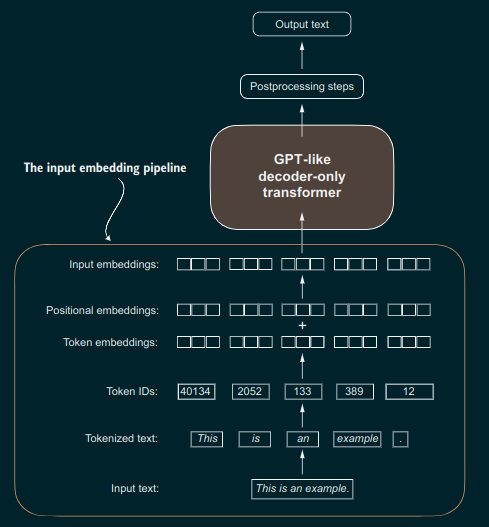